<h3>Algorithmic Machine Learning Challenge</h3>
<h1>Plankton Image Classification</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

# Introduction

This report is divided into two parts, one about predicting the 2nd taxonomic level of a considered image using Convolutionnal Neural Network, another one using features related to the same image. We firstly intended to focus on CNNs, because on the one hand we thought it would have been interesting to do some Computer Vision, and on the other hand we have already work with a Features Exploitation approach for the *House Pricing Challenge*. However, as we faced some difficulties with CNN, we also tried the other approach in order to find a proper model regarding the f1 score evaluation metric.

# 1 - Data Exploration
## 1a . First general approach

At the very beginning of our work on this challenge, we stuck to the quick how-to given in the statement and used the `extract_zip_to_memory()` method to visualyze parts of the images dataset contained in the archive `imgs.zip`.

In [3]:
import zipfile
from io import BytesIO
from PIL import Image
import numpy as np

def extract_zip_to_memory(input_zip):
    '''
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    '''
    input_zip=zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}

base = '/mnt/datasets/plankton/flowcam/'

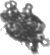

In [3]:
img_files = extract_zip_to_memory(base +'imgs.zip')
Image.open(img_files['imgs/32738710.jpg'])

We have two ways to show the images : either like in previous cell, or by working with numpy arrays and matplotlib (see the following).

In [18]:
import matplotlib.pyplot as plt

np_arr = np.array(Image.open(img_files['imgs/32738710.jpg']))
plt.imshow(np_arr, cmap='gray')

As explained in the statements, the most important information about all these images is contained in `metadata.csv` : let's display the row related to the previous image. 

In [4]:
import pandas as pd

metadata = pd.read_csv(base + 'meta.csv', 
                       sep=',', 
                       header='infer')

display(metadata.loc[metadata['objid'] == 32738710])

objid  projid     id status   latitude  longitude     objdate  \
129739  32738710.0     133  84963      V  43.683333        7.3  2013-06-27   

         objtime  depth_min  depth_max unique_name                 lineage  \
129739  00:08:30          0         75    detritus  /#/not-living/detritus   

          level1    level2  
129739  detritus  detritus

So the image identified through the id *32738710* actually represents a detritus. This class is findable in columns `unique_name`, `level1` and `level2`. Level one and two are two taxonomical level, so they can be different. Level one will always be the finest, but actually this challenge aims at predicting the *level two* label, which is easier.

Let's just see the whole hierarchical taxonomic tree we are working on, contained in `taxo.csv`.

In [10]:
taxodata = pd.read_csv(base + 'taxo.csv', 
                       sep=',', 
                       header='infer')

listtaxo = np.array(taxodata['levelName'])
for word in listtaxo:
    print(word)

#
¦--living
¦   ¦--Bacteria
¦   ¦   °--Cyanobacteria
¦   ¦       °--Cyanophyceae
¦   ¦           °--Trichodesmium
¦   ¦--Eukaryota
¦   ¦   ¦--Harosa
¦   ¦   ¦   ¦--Alveolata
¦   ¦   ¦   ¦   ¦--Ciliophora
¦   ¦   ¦   ¦   ¦   °--Intramacronucleata
¦   ¦   ¦   ¦   ¦       ¦--Oligohymenophorea
¦   ¦   ¦   ¦   ¦       ¦   °--Peritrichia
¦   ¦   ¦   ¦   ¦       ¦       °--Zoothamniidae
¦   ¦   ¦   ¦   ¦       ¦--Prostomatea
¦   ¦   ¦   ¦   ¦       ¦   °--Prostomatea X
¦   ¦   ¦   ¦   ¦       ¦       °--Colepidae
¦   ¦   ¦   ¦   ¦       ¦           °--Tiarina
¦   ¦   ¦   ¦   ¦       ¦               °--Tiarina fusus
¦   ¦   ¦   ¦   ¦       °--Spirotrichea
¦   ¦   ¦   ¦   ¦           °--Choreotrichia
¦   ¦   ¦   ¦   ¦               ¦--Cyttarocylididae
¦   ¦   ¦   ¦   ¦               ¦   °--Cyttarocylis
¦   ¦   ¦   ¦   ¦               ¦--Dictyocystidae
¦   ¦   ¦   ¦   ¦               ¦   ¦--Codonaria
¦   ¦   ¦   ¦   ¦               ¦   ¦--Codonellopsis
¦   ¦   ¦   ¦   ¦               ¦   °--Dict

The whole hierarchical taxonomic tree is huge, but we should focus on the labels in our targeted column `level2` of `metadata`.

In [12]:
print('nb of uniques values in column level2 : ' + str(metadata['level2'].nunique()))
print('nb of raws in metadata : ', len(metadata) )

nb of uniques values in column level2 : 39
nb of raws in metadata :  243610


So we will try to find the right label between 39 different classes to 243610 rows/images. 
However, before we go any further, we should make sure the `metadata` dataframe is correctly filled. 

In [3]:
metadata.isnull().any().any()

True

Ah. It's not good news. Let's look for the location of these NaN values.

In [13]:
metadata.isna().sum()

objid             0
projid            0
id                0
status            0
latitude          0
longitude         0
objdate           0
objtime           0
depth_min         0
depth_max         0
unique_name       0
lineage           0
level1         3334
level2         1003
dtype: int64

The fact that these NaN values are in columns `level1` & `level2` means that, for some images, we don't have any label. As it's the aim of our predictive model, it's a big problem. We simply cannot work with those images. We can't train our future model with them, because it cannot modify itself according to the potential gap between its prediction and the true value if it cannot know the true value. We can't test it either for the same reason.

As a consequence, we would like to drop the rows containing those NaN values, and declare the related images as non-usable:
* In level1, we don't have to worry about NaN values, because it's not our target prediction
* In level2, we have 1003 embarrasing NaN values out of 243 610 : it represents only 0.4% of our dataset. 

We can safely hope removing NaN values in `level2` colummn won't have  negative impact.

In [5]:
clean_metadata = metadata.dropna(subset=['level2'])  #the 'subset' parameter defines in which columns to look for missing values.

From now on, we will work only with images or rows from `features_native.csv` or `features_skimage.csv` identified in our `clean_metadata` DataFrame. For this reason, we will keep in memory the `objid` of the dropped rows in the array `objid_not_to_use`.  We will also keep in memory an array containing all the classes' names.

In [6]:
dropped_rows = metadata[~metadata.index.isin(clean_metadata.index)]
objid_not_to_use = dropped_rows['objid'].values

classes = clean_metadata['level2'].drop_duplicates().values.tolist()

So now, we are working with objects that are for sure assigned to one of the 39 labels of `level2`. We would like to know more about the distribution of the data among these classes.

In [7]:
s1 = clean_metadata['level2'].value_counts(ascending=True) #returns quantity of images in the class
s2 = clean_metadata['level2'].value_counts(ascending=True, normalize=True) # normilizing it between 0 and 1 will help to comput the percentage later

print(s1.describe())

d = {'A quantity of images in the class' : s1, 
      'B % representation of the dataset' : s2*100} 
  
df = pd.DataFrame(d) 
df

count        39.000000
mean       6220.692308
std       22287.395542
min          12.000000
25%         224.000000
50%         710.000000
75%        3074.500000
max      138439.000000
Name: level2, dtype: float64


A quantity of images in the class  \
Bacteriastrum                                                  12   
Xystonellidae                                                  37   
tempChaetoceros danicus                                        61   
Lithodesmioides                                                68   
Cyttarocylis                                                  100   
Asterionellopsis                                              117   
Odontella (Mediophyceae)                                      131   
centric                                                       145   
Ceratocorys horrida                                           186   
Pleurosigma                                                   191   
Retaria                                                       257   
Coscinodiscids                                                334   
Stenosemella                                                  357   
Rhabdonella                                                   367   
Annelida                                                      481   
Dinophysiales                                                 525   
Dictyocysta                                                   549   
Hemiaulus                                                     670   
egg (other)                                                   685   
Undellidae                                                    710   
chainlarge                                                    751   
Codonaria                                                     845   
pollen                                                       1821   
artefact                                                     1849   
Chaetoceros                                                  2105   
Rhizosolenids                                                2160   
Tintinnidiidae                                               2227   
Protoperidinium                                              2256   
Codonellopsis (Dictyocystidae)                               2888   
multiple (other)                                             3261   
rods                                                         4044   
Thalassionema                                                5117   
Copepoda                                                     5141   
silks                                                        5629   
badfocus (artefact)                                          7848   
nauplii (Crustacea)                                          9293   
Neoceratium                                                 14014   
feces                                                       26936   
detritus                                                   138439   

                                B % representation of the dataset  
Bacteriastrum                                            0.004946  
Xystonellidae                                            0.015251  
tempChaetoceros danicus                                  0.025144  
Lithodesmioides                                          0.028029  
Cyttarocylis                                             0.041219  
Asterionellopsis                                         0.048226  
Odontella (Mediophyceae)                                 0.053997  
centric                                                  0.059767  
Ceratocorys horrida                                      0.076667  
Pleurosigma                                              0.078728  
Retaria                                                  0.105933  
Coscinodiscids                                           0.137671  
Stenosemella                                             0.147152  
Rhabdonella                                              0.151273  
Annelida                                                 0.198263  
Dinophysiales                                            0.216399  
Dictyocysta                                              0.226292  
Hemiaulus                                      

Some classes represent 0.005% of the entire dataset, whereas another occupies 57% of it. The numbers are enough to show that the distribution is far from being uniform, but let's be more visual.

In [49]:
import seaborn as sns
from matplotlib import gridspec

figure = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
font = {'family': 'serif', 'color':  'navy', 'weight': 'normal', 'size': 12}

plt.subplot(gs[0])
pie = plt.pie(sizes,startangle=90)
plt.legend(pie[0], labels, bbox_to_anchor=(0.5, 0.5), loc="center", fontsize=10, bbox_transform=plt.gcf().transFigure)
plt.axis('equal')
plt.title("Pie chart of the number of images from each class")


plt.subplot(gs[1])
plt.title("Boxplot of the number of images from each class")

plt.text(0.75, 138439, str(s1.index[-1]+' : '+ str(s1[-1])), fontdict=font)
plt.text(0.75, 26936, str(s1.index[-2]+' : '+ str(s1[-2])), fontdict=font)
plt.text(0.75, 14014, str(s1.index[-3]+' : '+ str(s1[-3])), fontdict=font)
plt.text(0.75, 9650, str(s1.index[-4]+' : '+ str(s1[-4])), fontdict=font)
plt.text(0.75, 7450, str(s1.index[-5]+' : '+ str(s1[-5])), fontdict=font)

sns.boxplot(data=s1)

The pie chart and the boxplot show clearly 5 outlyers *detritus*, *feces*, *Neoceratium*, *nauplii (Crustacea)*, *badfocus (artefact)*. We might need to consider them later during the **Data Pre-processing** part.

## 1b . Data exploration for features exploitation approach

In addition to the archive zip file containing the images, the `metadata.csv` file providing us our target prediction, and the `taxodata.csv` file giving us the whole taxonomy, we have two more .csv files on which we can work.

As explaind in the statements : 
>* `features_native.csv.gz` contain the morphological handcrafted features computed by ZooProcess. In fact, ZooProcess generates the region of interests (ROI) around each individual object from a original image of Plankton. In addition, it also computes a set of associated features measured on the object. These features are the ones contained in `features_native.csv.gz`
>* `features_skimage.csv.gz` contains the morphological features recomputed with skimage.measure.regionprops on the ROIs produced by ZooProcess

So, the first DataFrame will contain features extracted from our images using ZooProcess, a software developped by an engineer from the Laboratoire d’Océanologie de Villefranche sur mer. That's why we can say they are "handcrafted". Let's see what they look like and display the information concerning again our example detritus image.

In [8]:
nativedata = pd.read_csv(base + 'features_native.csv.gz', 
                         sep=',', 
                         header='infer')

display(nativedata.loc[nativedata['objid'] == 32738710])

objid    area  meanimagegrey    mean  stddev  min  perim.  width  \
129739  32738710.0  1571.0         165.06  218.26  46.026  125  216.25     50   

        height  major      ...        symetriev_area  nb1_area  nb2_area  \
129739      55   71.1      ...              0.006061  0.030303  0.006061   

        nb3_area  nb1_range  nb2_range  nb3_range  median_mean  \
129739  0.012121   0.038462   0.007692   0.015385           33   

        median_mean_range  skeleton_area  
129739           0.253846      22.145455  

[1 rows x 65 columns]

Let's do the same for the second DataFrame.

In [9]:
skimagedata = pd.read_csv(base + 'features_skimage.csv.gz', 
                           sep=',', 
                           header='infer')

display(skimagedata.loc[skimagedata['objid'] == 32738710])

objid    area  convex_area  eccentricity  equivalent_diameter  \
212114  32738710.0  1542.0       1888.0      0.793039             44.30954   

        euler_number  filled_area  inertia_tensor0  inertia_tensor1  \
212114            -5       1571.0        142.65545       -67.672108   

        inertia_tensor2              ...                \
212114       -67.672108              ...                 

        weighted_moments_normalized6  weighted_moments_normalized7  \
212114                    839.218195                    382.266859   

        weighted_moments_normalized8  weighted_moments_normalized9  \
212114                 580442.252198                   -331.423713   

        weighted_moments_normalized10  weighted_moments_normalized11  \
212114                     372.546301                      -0.065151   

        weighted_moments_normalized12  weighted_moments_normalized13  \
212114                    -939.096335                     322.856554   

        weighted_moments_normalized14  weighted_moments_normalized15  
212114                       0.056764                       0.405794  

[1 rows x 66 columns]

The question we should ask ourself is the following : should we use both sources of information?

As said before, the second DataFrame is based on the first : it uses the Regions Of Interests (=ROI) defined by the ZooProcess software as inputs of the function `regionprops()`, of the python `skimage.measure` library. As a consequence, the second DataFrame might give redundant infos compared to the first one. In our example, we find the same values in columns *area* from `nativedata` and *filled_area* from `skimagedata`.

However, we believed there are also relevant new features in `skimagedata`. We've decided to merge both tables, and care about redundancy after this step (see the **Data Pre-processing** part for more). Also, as explained before, we can already drop from the two DataFrames the lines that are not in `clean_metadata`, ie the ones that had NaN value in *level2* column. 

In [17]:
clean_nativedata = nativedata
for x in objid_not_to_use :
    clean_nativedata = clean_nativedata[clean_nativedata.objid != x]

clean_skimagedata = skimagedata
for x in objid_not_to_use :
    clean_skimagedata = clean_skimagedata[clean_skimagedata.objid != x]

## 1c . Data exploration for CNN approach

Convolutional Neural Network are very usefull when it comes to computer vision, because they don't see images simply as pixels listed one after the other, but as several local regions. 

As a consequence, it might be usefull to know more about our images data. Let's simply print the array behind an image (here the same detritus image as before)

In [46]:
print(np_arr)
print(np_arr.shape)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
(55, 50)


Regarding its dimensions, it fits with the one-channel gray almost square image we saw before.

Let's be sure we are working only with one-channel images, ie with one whose shapes are tuples.

In [43]:
list_nb_dimensions_of_image = []

for ids in metadata['objid'].values:
    key = 'imgs/'+ str(int(ids)) +'.jpg'
    a = np.array(Image.open(img_files[key]))
    nb_dimensions_of_image = len(a.shape)
    if nb_dimensions_of_image not in list_nb_dimensions_of_image:
        list_nb_dimensions_of_image.append(nb_dimensions_of_image)
        
print(list_nb_dimensions_of_image)

[2]


So we are sure that we will only work with images in shades of gray, ie one-channel images.

But what about the distribution of the different image dimensions? Let's use informations contained in `nativedata.csv` to draw some boxplots about all widths and heights.

Desciption of the distribution of all widths :
count    242607.000000
mean         86.919994
std          62.084493
min           6.000000
25%          50.000000
50%          67.000000
75%         104.000000
max         972.000000
Name: width, dtype: float64

Desciption of the distribution of all heights :
count    242607.000000
mean        109.665727
std          71.825537
min           9.000000
25%          61.000000
50%          87.000000
75%         135.000000
max         739.000000
Name: height, dtype: float64


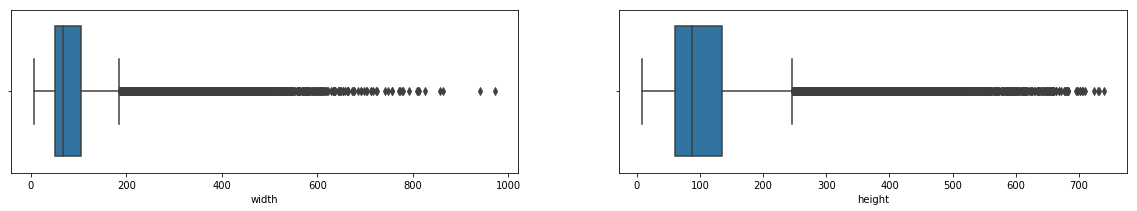

In [42]:
import seaborn as sns
from matplotlib import gridspec
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(20,3))
gs = gridspec.GridSpec(1, 2) 

print("Desciption of the distribution of all widths :")
print(clean_nativedata["width"].describe())
plt.subplot(gs[0])
sns.boxplot(x='width', data=clean_nativedata)
print()

print("Desciption of the distribution of all heights :")
print(clean_nativedata["height"].describe())
plt.subplot(gs[1])
sns.boxplot(x='height', data=clean_nativedata)

Because CNN imply fully connected layers, we need to feed them with images of the same size - and as the previous boxplots show it, the distribution of widths and heights, we have quite a lot of varying sizes. We have several ways to cope with this issue :
* if the image is bigger than the arbitrarly fixed size, we can do *Center-cropping*
* if the image is smaller, we can do *Padding* (ie adding zeroes or 255 on the sides)
* simply squashing the images, hopping that the network might learn to make sense of the content anyway

For lack of time, we went for the last and simpliest option.

# 2 - Data Preprocessing
## 2a . Data Preprocessing for CNN approach

As explained in the statements :
>[We] do not need to create a modified version of the dataset and save it to disk. Instead, the dataloader processes the data "on the fly" and in-memory before passing it to the network.

We decided to go for the Dataloader from the `pytorch` library. This library is useful for both **Data Pre-processing** and **Model selection, evaluation and optimisation**.

We freely drew inspiration from this tutorial : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html . The first thing to do is to define our customed version of what our pytorch Dataset class should contain, to do a proper data loading.

In [48]:
import zipfile
from skimage import io
from torch.utils.data import Dataset, DataLoader

class ImageLabelsDataset(Dataset):
    """Image Labels dataset."""

    def __init__(self, dataframe, root_dir_zip, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = dataframe
        self.root_dir_zip = root_dir_zip
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = 'imgs/' + str(int(self.dataframe.iloc[idx]['objid'])) +'.jpg'
        image = io.imread(BytesIO(zipfile.ZipFile(self.root_dir_zip).read(img_name)))
       
        str_label = self.dataframe.iloc[idx]['level2']
        label = classes.index(str_label)

        sample = image, label

        if self.transform:
            sample = self.transform(sample)
        return sample

The whole point of this pytorch Dataset object is that it doesn't store the images in memory at once, but read them only as required, through the `__getitem__` method. This is supposed to improve memory efficiency. 

This ImageLabelsDataset class was all what we need for data loading, now we can really do some data preprocessing. In this context, we will write our own pytorch Transforms, adapted to our custom ImageLabelsDataset. Firstly, as we mentionned it earlier, we need to give a fixed size to all our images - this is the aim of the following `Rescale()` function.

In [57]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return img, label

Then, as we are using the pytorch workframe, we need a Tranform to convert our objects (here an image and a string label) into Tensors - this is the aim of the following `ToTensor()` function.

In [53]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample
        image = torch.from_numpy(image)
        image = image.unsqueeze(0) #to accentuate the fact that we aare working with one-channel images
        return image, torch.tensor(label)  

Finally we want to normalize the pixel's values, simply because we believe many learning algorithms behave well with normalized data.

In [54]:
from torchvision import transforms

class Normalize(object):
    """Normalize a tensor image with mean and standard deviation."""

    def __call__(self, sample):
        image, label = sample
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        return image, label  

All these Transforms can be done "at the same time" using `torchvion.transforms.Compose()` method. 

Let’s put this all together to create our first ImageLabelsDataset with composed transforms. To summarize, every time this dataset is sampled, an image is read from the file on the fly and Transforms are applied on this read image.

In [58]:
from torchvision import transforms

transformed_dataset = ImageLabelsDataset(dataframe = clean_metadata, 
                                        root_dir_zip = '/mnt/datasets/plankton/flowcam/imgs.zip',
                                        transform = transforms.Compose([
                                            Rescale((32,32)),
                                            ToTensor(), 
                                            Normalize()
                                        ]))

We could iterate over the created dataset with a simple "for i in range" loop, but the best - and the aim of all this classes - is to use a pytorch DataLoader. This iterator enables us to batch and shuffle the data, and to load it in parallel using multiprocessing workers. 

However, we won't pass this `transformed_dataset` as argument of a Dataloader immediatly. While going through this challenge, we saw the need of working on small Datasets, for a question of time cost. We will begin by reducing the numbers of rows given in the *dataframe* argument, more precisely we will work with DataFrames of less than 5000 rows.  

In [83]:
little_clean_metadata = clean_metadata.sample(n=4400)
s3 = little_clean_metadata['level2'].value_counts()

while((len(s3.index) != 39)):  #while all the 39 labels from clean_metadata are not represented in little_clean_metadata
    little_clean_metadata = clean_metadata.sample(n=4400) #resample
    s3 = little_clean_metadata['level2'].value_counts()

print("now we can safely use little_clean_metadata, which has ", len(little_clean_metadata), " rows.")

now we can safely use little_clean_metadata, which has  4400  rows.


Let's compare the distribution of the data among our 39 classes of this more little version of `metadata` with the original.

In [77]:
s4 = little_clean_metadata['level2'].value_counts(normalize=True)

# Intialise data to Dicts of series. 
d = {'A quantity in original dataset' : s1, 
      'B percent from original dataset' : s2*100,
     'C quantity in cropped dataset' : s3, 
      'D percent from cropped dataset' : s4*100} 

# creates Dataframe. 
df = pd.DataFrame(d) 
df

A quantity in original dataset  \
Annelida                                                   481   
Asterionellopsis                                           117   
Bacteriastrum                                               12   
Ceratocorys horrida                                        186   
Chaetoceros                                               2105   
Codonaria                                                  845   
Codonellopsis (Dictyocystidae)                            2888   
Copepoda                                                  5141   
Coscinodiscids                                             334   
Cyttarocylis                                               100   
Dictyocysta                                                549   
Dinophysiales                                              525   
Hemiaulus                                                  670   
Lithodesmioides                                             68   
Neoceratium                                              14014   
Odontella (Mediophyceae)                                   131   
Pleurosigma                                                191   
Protoperidinium                                           2256   
Retaria                                                    257   
Rhabdonella                                                367   
Rhizosolenids                                             2160   
Stenosemella                                               357   
Thalassionema                                             5117   
Tintinnidiidae                                            2227   
Undellidae                                                 710   
Xystonellidae                                               37   
artefact                                                  1849   
badfocus (artefact)                                       7848   
centric                                                    145   
chainlarge                                                 751   
detritus                                                138439   
egg (other)                                                685   
feces                                                    26936   
multiple (other)                                          3261   
nauplii (Crustacea)                                       9293   
pollen                                                    1821   
rods                                                      4044   
silks                                                     5629   
tempChaetoceros danicus                                     61   

                                B percent from original dataset  \
Annelida                                               0.198263   
Asterionellopsis                                       0.048226   
Bacteriastrum                                          0.004946   
Ceratocorys horrida                                    0.076667   
Chaetoceros                                            0.867658   
Codonaria                                              0.348300   
Codonellopsis (Dictyocystidae)                         1.190403   
Copepoda                                               2.119065   
Coscinodiscids                                         0.137671   
Cyttarocylis                                           0.041219   
Dictyocysta                                            0.226292   
Dinophysiales                                          0.216399   
Hemiaulus                                              0.276167   
Lithodesmioides                                        0.028029   
Neoceratium                                            5.776420   
Odontella (Mediophyceae)                               0.053997   
Pleurosigma                                            0.078728   
Protoperidinium                                        0.929899   
Retaria                                                0.105933   
Rhabdonella                                        

The stratification seems to be quite respected. But, as we saw it earlier in the **Data exploration** part, the *detritus* class is a really heavy one. Even if it disrespect the distribution of the original data that was given to us, we will also create another version of `metadata`, but with only 100 *detritus*, and extract a sample from it.

In [79]:
n = 0
nb_detritus = 0
indexs_of_rows_to_delete = []
while(n<len(clean_metadata)): #while going through clean_metadata
    row = clean_metadata.iloc[n]
    if (row['level2'] == 'detritus'): #if the row considered is a detritus
        if (nb_detritus < 100):           #if we have'nt reach 100 detritus yet
            nb_detritus += 1                    #keep going
        else:                             #else        
            indexs_of_rows_to_delete.append(row.name)  #keep in memory the index of the row we will drop after
    n += 1

only100d_clean_metadata = clean_metadata.drop(indexs_of_rows_to_delete)

In [82]:
little_only100d_clean_metadata = only100d_clean_metadata.sample(n=4400)
s5 = little_only100d_clean_metadata['level2'].value_counts()

while((len(s3.index) != 39)):  #while all the 39 labels from clean_metadata are not represented in little_clean_metadata
    little_only100d_clean_metadata = only100d_clean_metadata.sample(n=4400) #resample
    s5 = little_only100d_clean_metadata['level2'].value_counts()

print("now we can safely use little_only100d_clean_metadata, which has ", len(little_only100d_clean_metadata), " rows.")

now we can safely use little_only100d_clean_metadata, which has  4400  rows.


Just to make it clearer, let's visualize the distribution of our new samples of data among our 39 classes with boxplots.

In [92]:
figure = plt.figure(figsize=(18,7))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.4) 

plt.subplot(gs[0])
plt.title("distribution of data among our 39 classes for little_clean_metadata")
sns.boxplot(s3)

plt.subplot(gs[1])
plt.title("distribution of data among our 39 classes for little_only100d_clean_metadata")
sns.boxplot(s5)


We will see in the part **Model selection, evaluation and optimisation** if working with less skewed data improves the model. For now, let's finally build all the Dataloader we will need later. This means splitting our new Datasets for training and testing.

In [93]:
transformed_dataset = ImageLabelsDataset(dataframe = little_clean_metadata, 
                                        root_dir_zip = '/mnt/datasets/plankton/flowcam/imgs.zip',
                                        transform=transforms.Compose([
                                            Rescale((32,32)),  #resizing to 32x32 might be a huge compression, chosen for time cost
                                            ToTensor(), 
                                            Normalize()
                                           ]))

only100d_transformed_dataset = ImageLabelsDataset(dataframe = little_only100d_clean_metadata, 
                                        root_dir_zip = '/mnt/datasets/plankton/flowcam/imgs.zip',
                                        transform=transforms.Compose([
                                            Rescale((32,32)),
                                            ToTensor(), 
                                            Normalize()
                                           ]))

In [94]:
import torch

train_size = int(0.8 * len(transformed_dataset))
test_size = len(transformed_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, test_size])

only100d_train_size = int(0.8 * len(only100d_transformed_dataset))
only100d_test_size = len(only100d_transformed_dataset) - only100d_train_size
only100d_train_dataset, only100d_test_dataset = torch.utils.data.random_split(only100d_transformed_dataset, [only100d_train_size, only100d_test_size])

In [96]:
trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

only100d_trainloader = DataLoader(only100d_train_dataset, batch_size=4, shuffle=True, num_workers=2)
only100d_testloader = DataLoader(only100d_test_dataset, batch_size=4, shuffle=False, num_workers=2)

We are now ready to make predictions working with our Dataloader!

## 2b . Data Preprocessing for features exploitation approach

Our first goal in this part is to remove all the unnecessary ; we have currently 242 607 rows to work on, we can afford ourselves to clean a little.

### *Dealing with clean_metadata*
Obviously, `clean_metadata` doesn't contain any NaN values - we've built it that way. Still, let's check its content again to see if we can do anything.

In [39]:
clean_metadata.head()

objid  projid     id status   latitude  longitude     objdate  \
0  32756761.0     133  84963      V  43.683333        7.3  2013-09-19   
1  32759364.0     133  84963      V  43.683333        7.3  2013-09-19   
2  32758055.0     133  28299      V  43.683333        7.3  2013-09-19   
3  32758988.0     133  92010      V  43.683333        7.3  2013-09-19   
4  32760598.0     133  92010      V  43.683333        7.3  2013-09-19   

    objtime  depth_min  depth_max unique_name  \
0  00:09:00          0         75    detritus   
1  00:09:00          0         75    detritus   
2  00:09:00          0         75   Guinardia   
3  00:09:00          0         75       silks   
4  00:09:00          0         75       silks   

                                             lineage     level1         level2  
0                             /#/not-living/detritus   detritus       detritus  
1                             /#/not-living/detritus   detritus       detritus  
2  /#/living/Eukaryota/Harosa/Stramenopiles/Ochro...  Guinardia  Rhizosolenids  
3                  /#/not-living/plastic/other/silks      silks          silks  
4                  /#/not-living/plastic/other/silks      silks          silks

We have a lot of columns that doesn't seem usefull for our prediction, or that could induce overfitting (suppose all the photo taken one specific day concerns only one specy, then any algorithm could give weight to the *objdate* column, which doesn't seem appropriate for future utilisation of our model). We simply droped them and create the `usefull_clean_metadata` DataFrame.

In [14]:
usefull_clean_metadata = clean_metadata.drop(['projid', 'id', 'status', 'objdate', 'objtime','depth_min', 'depth_max', 'unique_name', 'lineage', 'level1'], axis=1)

In [15]:
usefull_clean_metadata.head()

objid   latitude  longitude         level2
0  32756761.0  43.683333        7.3       detritus
1  32759364.0  43.683333        7.3       detritus
2  32758055.0  43.683333        7.3  Rhizosolenids
3  32758988.0  43.683333        7.3          silks
4  32760598.0  43.683333        7.3          silks

### *Dealing with clean_nativedata*

First things first, we will look for NaNs in our `clean_nativedata` DataFrame.

In [64]:
if(clean_nativedata.isna().any().any()): #if there are NaN
    print("There are ", clean_nativedata.isna().any().sum(), "colums with NaN.")
else:
    print("no NaN here")

There are  10 colums with NaN.


In [31]:
clean_nativedata.isna().sum()

objid                    0
area                     0
meanimagegrey            0
mean                     0
stddev                   0
min                      0
perim.                   0
width                    0
height                   0
major                    0
minor                    0
angle                    0
circ.                    0
feret                    0
intden                   0
median                   0
skew                     0
kurt                     0
%area                    0
area_exc                 0
fractal                  0
skelarea                 0
slope                    0
histcum1                 0
histcum2                 0
histcum3                 0
nb1                      0
nb2                      0
nb3                      0
symetrieh                0
                     ...  
fcons                    0
thickr                   0
esd                      0
elongation               0
range                    0
meanpos                  0
c

We can remark that the number of NaN in different columns takes only two values. Maybe they are from the same rows, where the info is missing... Let's drop all rows containing NaN in *perimareaexc* column and see what's happenning.

In [22]:
temp_clean_nativedata = clean_nativedata.dropna(subset=['perimareaexc']) 
temp_clean_nativedata.isna().sum()

objid                   0
area                    0
meanimagegrey           0
mean                    0
stddev                  0
min                     0
perim.                  0
width                   0
height                  0
major                   0
minor                   0
angle                   0
circ.                   0
feret                   0
intden                  0
median                  0
skew                    0
kurt                    0
%area                   0
area_exc                0
fractal                 0
skelarea                0
slope                   0
histcum1                0
histcum2                0
histcum3                0
nb1                     0
nb2                     0
nb3                     0
symetrieh               0
                     ... 
fcons                   0
thickr                  0
esd                     0
elongation              0
range                   0
meanpos                 0
centroids               0
cv          

This confirm what we were thinking : all NaN in columns *feretareaexc* and *cdexc* disappeared with the ones from *perimareaexc*. Let's repeat the operation with rows containing NaN in *convarea_area* column.

In [65]:
temp2_clean_nativedata = temp_clean_nativedata.dropna(subset=['convarea_area']) 

if(temp2_clean_nativedata.isna().any().any()): #if there are NaN
    print("There are ", temp2_clean_nativedata.isna().any().sum(), "colums with NaN.")
else:
    print("no NaN here")

no NaN here


Dropping all those 41057 (= 34302 + 6755) rows with NaN values, we would loose 17% of our initial data. Let's see to what extent it could endanger the diversity of the provided dataset.

In [27]:
tempDF = pd.merge(temp2_clean_nativedata, clean_metadata, left_on = 'objid', right_on='objid', how='inner')

s1 = clean_metadata['level2'].value_counts(ascending=True)
s2 = clean_metadata['level2'].value_counts(ascending=True, normalize=True)

s3 = tempDF['level2'].value_counts()
s4 = tempDF['level2'].value_counts(normalize=True)

# Intialise data to Dicts of series. 
d = {'A quantity in original dataset' : s1, 
      'B percent from original dataset' : s2*100,
     'C quantity in cropped dataset' : s3, 
      'D percent from cropped dataset' : s4*100} 

# creates Dataframe. 
df = pd.DataFrame(d) 
df

A quantity in original dataset  \
Annelida                                                   481   
Asterionellopsis                                           117   
Bacteriastrum                                               12   
Ceratocorys horrida                                        186   
Chaetoceros                                               2105   
Codonaria                                                  845   
Codonellopsis (Dictyocystidae)                            2888   
Copepoda                                                  5141   
Coscinodiscids                                             334   
Cyttarocylis                                               100   
Dictyocysta                                                549   
Dinophysiales                                              525   
Hemiaulus                                                  670   
Lithodesmioides                                             68   
Neoceratium                                              14014   
Odontella (Mediophyceae)                                   131   
Pleurosigma                                                191   
Protoperidinium                                           2256   
Retaria                                                    257   
Rhabdonella                                                367   
Rhizosolenids                                             2160   
Stenosemella                                               357   
Thalassionema                                             5117   
Tintinnidiidae                                            2227   
Undellidae                                                 710   
Xystonellidae                                               37   
artefact                                                  1849   
badfocus (artefact)                                       7848   
centric                                                    145   
chainlarge                                                 751   
detritus                                                138439   
egg (other)                                                685   
feces                                                    26936   
multiple (other)                                          3261   
nauplii (Crustacea)                                       9293   
pollen                                                    1821   
rods                                                      4044   
silks                                                     5629   
tempChaetoceros danicus                                     61   

                                B percent from original dataset  \
Annelida                                               0.198263   
Asterionellopsis                                       0.048226   
Bacteriastrum                                          0.004946   
Ceratocorys horrida                                    0.076667   
Chaetoceros                                            0.867658   
Codonaria                                              0.348300   
Codonellopsis (Dictyocystidae)                         1.190403   
Copepoda                                               2.119065   
Coscinodiscids                                         0.137671   
Cyttarocylis                                           0.041219   
Dictyocysta                                            0.226292   
Dinophysiales                                          0.216399   
Hemiaulus                                              0.276167   
Lithodesmioides                                        0.028029   
Neoceratium                                            5.776420   
Odontella (Mediophyceae)                               0.053997   
Pleurosigma                                            0.078728   
Protoperidinium                                        0.929899   
Retaria                                                0.105933   
Rhabdonella                                        

As we can see, globally all the proportions of the resulting table are the same as the original dataset except for one category, the "artefact". But what we can observe is that it is not a plankton category and there is also a category "badfocus (artefact)" which surely contains the same information. 

In [30]:
cleaner_nativedata = temp2_clean_nativedata

As a consequence, it is not so damageful to work with the `cleaner_nativedata` Dataframe. 

### *Dealing with clean_skimagedata*

As always, we will begin by looking for NaN.

In [66]:
if(clean_skimagedata.isna().any().any()): #if there are NaN
    print("There are ", clean_skimagedata.isna().any().sum(), "colums with NaN.")
else:
    print("no NaN here")

There are  6 colums with NaN.


In [29]:
clean_skimagedata.isna().sum()

objid                                 0
area                                  0
convex_area                           0
eccentricity                          0
equivalent_diameter                   0
euler_number                          0
filled_area                           0
inertia_tensor0                       0
inertia_tensor1                       0
inertia_tensor2                       0
inertia_tensor3                       0
inertia_tensor_eigvals0               0
inertia_tensor_eigvals1               0
major_axis_length                     0
max_intensity                         0
mean_intensity                        0
min_intensity                         0
minor_axis_length                     0
moments_hu0                           0
moments_hu1                           0
moments_hu2                           0
moments_hu3                           0
moments_hu4                           0
moments_hu5                           0
moments_hu6                           0


We see the number of NaN in some columns is exactly the number of rows, meaning that those columns are useless. Let's simply drop them.

In [31]:
cleaner_skimagedata = clean_skimagedata.drop(['moments_normalized0', 'moments_normalized1', 'moments_normalized4', 
                                           'weighted_moments_normalized0', 'weighted_moments_normalized1', 'weighted_moments_normalized4'], axis=1) 

We can work with `cleaner_skimagedata` without fear of NaN values.

### *Merging our three cleaned DataFrames*

In [32]:
temp_dataset = pd.merge(cleaner_skimagedata, cleaner_nativedata, left_on = 'objid', right_on='objid', how='inner')
augmented_dataset = pd.merge(temp_dataset, usefull_clean_metadata, left_on = 'objid', right_on='objid', how='inner')

augmented_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201550 entries, 0 to 201549
Columns: 127 entries, objid to level2
dtypes: float64(106), int64(20), object(1)
memory usage: 196.8+ MB


We have now all our DataFrames in one, without any NaN (thanks to the inner join). If you remember what we said in part 1b,
>The second DataFrame might give redundant infos compared to the first one. [...]
We've decided to merge both tables, and care about redundancy after this step.

Taking care of redundancy is what we are about to do now, by checking the correlation between all the columns (not including our target one for trivial reasons) : we arbitrarly decided to removed one column of a pair being more than 97% correlated to each other.

In [33]:
corrDF = augmented_dataset.corr()

column_names = list(augmented_dataset.columns.values)
column_names.pop(column_names.index('level2'))

col_redundant = []
for col in column_names :
    a = corrDF[col].where(corrDF[col] > 0.97).dropna().index.values[0] 
    if (a != col):
        print(a, ' with ', col, ' gives correlation> 0.97')
        col_redundant.append(col)
print()
print("So, the columns that are to correlated to others are the following : ", col_redundant)

area_x  with  filled_area  gives correlation> 0.97
inertia_tensor1  with  inertia_tensor2  gives correlation> 0.97
moments_hu6  with  weighted_moments_hu6  gives correlation> 0.97
area_x  with  area_y  gives correlation> 0.97
major  with  feret  gives correlation> 0.97
intden  with  skelarea  gives correlation> 0.97
symetrieh  with  symetriev  gives correlation> 0.97
symetriehc  with  symetrievc  gives correlation> 0.97
intden  with  convperim  gives correlation> 0.97
intden  with  convarea  gives correlation> 0.97
meanimagegrey  with  esd  gives correlation> 0.97
symetrieh  with  elongation  gives correlation> 0.97
stddev  with  cv  gives correlation> 0.97
perimferet  with  perimmajor  gives correlation> 0.97
kurt  with  kurt_mean  gives correlation> 0.97
intden  with  convarea_area  gives correlation> 0.97
symetrieh_area  with  symetriev_area  gives correlation> 0.97
nb1  with  nb1_area  gives correlation> 0.97
nb1  with  nb1_range  gives correlation> 0.97
nb2  with  nb2_range  gives

In [36]:
augmented_dataset = augmented_dataset.drop(col_redundant, axis=1)   
augmented_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201550 entries, 0 to 201549
Columns: 105 entries, objid to level2
dtypes: float64(86), int64(18), object(1)
memory usage: 163.0+ MB


We got rid of too correlated columns and can work with the 105 left.

Then we have to normalize all our columns, ie. we change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. It is quite usefull here because our features do have different ranges.

In [97]:
from sklearn import preprocessing

X = augmented_dataset.drop('level2', axis=1) 
y = augmented_dataset['level2'] 

Xnorm, norms = preprocessing.normalize(X, norm='l2', return_norm=True, axis=0)

Finally, we split our `augmented_dataset` for training and testing. As we are working with several classes, an important aspect is to control this split :  we would like the proportion of values in the samples produced to be the same as the proportion of values in `augmented_dataset`. To do so, we provided `y` to the optional parameter `stratify` of the method `train_test_split()`.

In [98]:
from sklearn.model_selection import train_test_split

Xnorm_train, Xnorm_test, y_train, y_test = train_test_split(Xnorm, y, test_size=0.2, random_state=42, stratify=y)

We are now ready to make predictions working on all our features!

# 3 - Model selection and optimisation
## 3a . CNN approach

As mentionned earlier, the pytorch library is useful for Model selection, evaluation and optimisation. We will use it to build our very first Convolutional Neural Network, freely drawing inspiration from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py : 

In [99]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #1 because we work with one-channel images
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 90)
        self.fc2 = nn.Linear(90, 39) #39 because it's our number of targeted labels

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.float())))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.interpolate(x, size=(5, 5), mode='bilinear') 
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=39, bias=True)
)


Let's first use this simple CNN on our basic trainloader & testloader pair (ie with the skewed data). Firstly the training :

In [18]:
import time

print(time.asctime( time.localtime(time.time()) ))

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):

        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000), ' / ', time.asctime( time.localtime(time.time()) ))
            running_loss = 0.0

print('Finished Training')
print(time.asctime( time.localtime(time.time()) ))

Fri May  3 08:58:29 2019
[1,   100] loss: 0.140  /  Fri May  3 09:08:45 2019
[1,   200] loss: 0.097  /  Fri May  3 09:18:49 2019
[1,   300] loss: 0.096  /  Fri May  3 09:28:52 2019
[1,   400] loss: 0.094  /  Fri May  3 09:38:55 2019
[1,   500] loss: 0.097  /  Fri May  3 09:49:00 2019
[1,   600] loss: 0.091  /  Fri May  3 09:59:06 2019
[1,   700] loss: 0.091  /  Fri May  3 10:09:12 2019
[1,   800] loss: 0.086  /  Fri May  3 10:19:15 2019
[2,   100] loss: 0.081  /  Fri May  3 10:37:04 2019
[2,   200] loss: 0.085  /  Fri May  3 10:46:53 2019
[2,   300] loss: 0.084  /  Fri May  3 10:56:41 2019
[2,   400] loss: 0.088  /  Fri May  3 11:06:32 2019
[2,   500] loss: 0.083  /  Fri May  3 11:16:23 2019
[2,   600] loss: 0.083  /  Fri May  3 11:26:16 2019
[2,   800] loss: 0.078  /  Fri May  3 11:46:21 2019
Finished Training
Fri May  3 11:54:25 2019

Fri May  3 11:54:25 2019


NameError: name 'predicted' is not defined

*(You can ignore the Error raised, this part of the cell strictly correspond to what follows. We didn't re-run it, because it takes to much time for only 2 epochs on 3520 images - as the timestamps can attest.)*

Now comes the moment of thruth, the testing time of our model :

In [20]:
import time
from sklearn.metrics import f1_score

y_pred = []
y_test = []

class_correct = list(0. for i in range(39))
class_total = list(0. for i in range(39))

correct = 0
total = 0

print(time.asctime( time.localtime(time.time()) ))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicteds = torch.max(outputs, 1)
        c = (predicteds == labels).squeeze()
        total += labels.size(0)
        correct += (predicteds == labels).sum().item()
        for i in range(len(predicteds)):
            label = labels[i]
            y_test.append(classes[label.item()]) 
            prediction = predicteds[i]
            y_pred.append(classes[prediction.item()])
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
print('Finished Testing')   
print(time.asctime( time.localtime(time.time()) ))
print()

print("### F1_Score ###")
print("macro f1_score (=unweighted avg) : ", f1_score(y_test, y_pred, labels=classes, average='macro'))
print("micro f1_score (=avg weighing up large classes) : ", f1_score(y_test, y_pred, labels=classes, average='micro'))
print("customed f1_score (=forgetting unpredicted classes) : ", f1_score(y_test, y_pred, labels=np.unique(y_pred), average='macro'))
print()

print("### Accuracy ###")
print('Accuracy of the network on the ', total,' test images: %d %%' % (100 * correct / total))
print()

print("### Class per class Accuracy ###")
for i in range(39):
    if (class_total[i] != 0) :
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    else:
        print('cannot compute accuracy of class %5s (division/0)'% (classes[i]))

Fri May  3 11:59:31 2019
Finished Testing
Fri May  3 12:22:14 2019

### F1_Score ###
macro f1_score (=unweighted avg) :  0.018123928483957875
micro f1_score (=avg weighing up large classes) :  0.5465909090909091
customed f1_score (=forgetting unpredicted classes) :  0.7068332108743571

### Accuracy ###
Accuracy of the network on the  880  test images: 54 %

### Class per class Accuracy ###
Accuracy of detritus : 100 %
Accuracy of Rhizosolenids :  0 %
Accuracy of silks :  0 %
Accuracy of feces :  0 %
Accuracy of Codonaria :  0 %
Accuracy of Asterionellopsis :  0 %
Accuracy of Codonellopsis (Dictyocystidae) :  0 %
Accuracy of Dictyocysta :  0 %
Accuracy of Neoceratium :  0 %
Accuracy of Copepoda :  0 %
Accuracy of Coscinodiscids :  0 %
Accuracy of nauplii (Crustacea) :  0 %
Accuracy of Protoperidinium :  0 %
cannot compute accuracy of class Annelida (division/0)
cannot compute accuracy of class Ceratocorys horrida (division/0)
Accuracy of Dinophysiales :  0 %
Accuracy of Chaetoceros :  0

From all metrics we printed, the most important one is the **f1_score with macro averaging**. It is from **0.018123928483957875**, ie. barely 2%. 

If we read carefully our metrics, we understand that all detritus were predicted as detritus ("*Accuracy of detritus : 100 %*"), which on the surface seems great. It can also mean we have interpreted all images as 'detritus' - not so great. However, when we force the f1_score metric to "forget" all classes that weren't even predicted once, we don't reach the perfect 1 (but 0.7068332108743571) : it means we have given other predictions that 'detritus', which is better. But when looking at the accuracy class per class, it seems that those other predictions were mostly wrong. The mess doesn't stop here : for some classes, computing the accuracy would have lead to a division by 0, which means there are classes that are not even present in the `testloader`. The initial dataset of 4400 rows cannot be splitted onto train_dataset and test_dataset in a stratified way, because the data is too skewed.

After this quite disappointing result, we wanted to try with a stronger CNN, one with convolustional layers. Here is its definition:

In [1]:
import torch.nn as nn
import torch.nn.functional as F


class Net32(nn.Module):
    def __init__(self):
        super(Net32, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 24, 5)
        self.fc1 = nn.Linear(24 * 5 * 5, 90)
        self.fc2 = nn.Linear(90, 39)

    def forward(self, x):
        x = F.relu(self.conv1(x.float()))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.interpolate(x, size=(5, 5), mode='bilinear')        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net32 = Net32()
print(net32)

Net32(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=600, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=39, bias=True)
)


*(As the training and testing phases are very similar to the previous ones, we will give you only the outputs.)*

In [18]:
# Training net32() on trainloader

Thu May  2 19:15:04 2019
[1,   100] loss: 0.132
[1,   200] loss: 0.108
[1,   300] loss: 0.105
[1,   400] loss: 0.091
[1,   500] loss: 0.095
[1,   600] loss: 0.093
[1,   700] loss: 0.090
[1,   800] loss: 0.099
[2,   100] loss: 0.098
[2,   200] loss: 0.097
[2,   300] loss: 0.092
[2,   400] loss: 0.090
[2,   500] loss: 0.097
[2,   600] loss: 0.089
[2,   700] loss: 0.088
[2,   800] loss: 0.083
Finished Training
Thu May  2 22:01:33 2019


In [29]:
# Testing net32() on testloader

Thu May  2 22:55:11 2019
Finished Testing
Thu May  2 23:16:00 2019

### F1_Score ###
macro f1_score (=unweighted avg) :  0.02539639651863655
micro f1_score (=avg weighing up large classes) :  0.5488636363636363
customed f1_score (=forgetting unpredicted classes) :  0.4952297321134127

### Accuracy ###
Accuracy of the network on the  880  test images: 54 %

### Class per class Accuracy ###
Accuracy of detritus : 91 %
Accuracy of Rhizosolenids :  0 %
Accuracy of silks :  0 %
Accuracy of feces : 24 %
Accuracy of Codonaria :  0 %
Accuracy of Asterionellopsis :  0 %
Accuracy of Codonellopsis (Dictyocystidae) :  0 %
Accuracy of Dictyocysta :  0 %
Accuracy of Neoceratium :  0 %
Accuracy of Copepoda :  0 %
cannot compute accuracy of class Coscinodiscids (division/0)
Accuracy of nauplii (Crustacea) :  0 %
Accuracy of Protoperidinium :  0 %
cannot compute accuracy of class Annelida (division/0)
cannot compute accuracy of class Ceratocorys horrida (division/0)
cannot compute accuracy of class Din

Now the **f1_score with macro averaging** is from **0.02539639651863655**, which is a bit better. It also succeeded to predict some *feces* correctly.

It seems that adding layers helps the CNN to be better, but it's the "black box" part of it. We induced the too skewed data was also somwhat responsible for this low score, let's try this better CNN with the `only100d_trainloader` & `only100d_testloader` pair, ie with a bit less skewed data.

In [21]:
# Training net32() on only100d_trainloader

Thu May  2 19:18:11 2019
[1,   100] loss: 0.183
[1,   200] loss: 0.160
[1,   300] loss: 0.144
[1,   400] loss: 0.141
[1,   500] loss: 0.142
[1,   600] loss: 0.134
[1,   700] loss: 0.124
[1,   800] loss: 0.121
[2,   100] loss: 0.113
[2,   200] loss: 0.106
[2,   300] loss: 0.109
[2,   400] loss: 0.110
[2,   500] loss: 0.112
[2,   600] loss: 0.108
[2,   700] loss: 0.105
[2,   800] loss: 0.108
Finished Training
Thu May  2 21:57:36 2019


In [25]:
# Testing net32() on only100d_testloader

Thu May  2 22:55:32 2019
Finished Testing
Thu May  2 23:15:43 2019

### F1_Score ###
macro f1_score (=unweighted avg) :  0.04303248361762991
micro f1_score (=avg weighing up large classes) :  0.3868263473053893
customed f1_score (=forgetting unpredicted classes) :  0.3356533722175133

### Accuracy ###
Accuracy of the network on the  835  test images: 38 %

### Class per class Accuracy ###
Accuracy of detritus :  0 %
Accuracy of Rhizosolenids :  0 %
Accuracy of silks :  0 %
Accuracy of feces : 91 %
Accuracy of Codonaria :  0 %
Accuracy of Asterionellopsis :  0 %
Accuracy of Codonellopsis (Dictyocystidae) :  0 %
Accuracy of Dictyocysta :  0 %
Accuracy of Neoceratium : 43 %
Accuracy of Copepoda :  0 %
Accuracy of Coscinodiscids :  0 %
Accuracy of nauplii (Crustacea) : 16 %
Accuracy of Protoperidinium :  0 %
Accuracy of Annelida :  0 %
Accuracy of Ceratocorys horrida :  0 %
Accuracy of Dinophysiales :  0 %
Accuracy of Chaetoceros :  0 %
Accuracy of Thalassionema :  0 %
Accuracy of Undellid

Here the **f1_score with macro averaging** is from **0.04303248361762991**, which is twice better.

Our induction was correct, the data skewness harms the model. Doing Data Augmentation on the classes with very little individuals and cutting through more outlying classes, like *feces*, *Neoceratium*, *nauplii (Crustacea)*, or *badfocus (artefact)* would certainly lead us to better results, maybe better than the one we obtained with the **Features Exploitation** aproach.

## 3b . Features exploitation approach


**MODELISATION**
---

Perhaps the most important segment of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions. Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models.

The choice of your model is closely connected to the way you preprocessed the input data.

Furthermore, there are other factors which may influence your decision:

* What is the model's complexity?
* Is the model interpretable?
* Is the model capable of handling different data-types?
* Does the model return uncertainty estimates along with predictions?

1-Linear SVC
---

The first approach we are going to test is based on Support Vector Machines technique, which is a supervised learning method used for classification. LinearSVC is chosen because it is a particular class capable of performing multi-class classification on a dataset. 

Unlike other classifiers, the support vector machine is explicitly told to find the best separating line by searching the support vectors that separates the closest points between classes. Support vector machines focus particularly on the points that are the most difficult to tell apart, whereas other classifiers pay attention to all of the points.

The intuition behind the support vector machine approach is that if a classifier is good at the most challenging comparisons, then the classifier will be even better at the easy comparisons.


The advantages of support vector machines are:
* Effective in high dimensional spaces (useful for our 104 dimension space).
* Uses a subset of training points in the decision function (support vectors), so it is also memory efficient.

The disadvantages of support vector machines include:
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

* **Algorithm complexity**
---

Support Vector Machines are powerful tools, but their compute and storage requirements increase rapidly with the number of training vectors. The core of an SVM is a quadratic programming problem (QP), separating support vectors from the rest of the training data. The QP solver used by this libsvm-based implementation scales between 
$O( n_{features} \times n_{samples}^2)$ and $O( n_{features} \times n_{samples}^3)$ depending on how efficiently the libsvm cache is used in practice.

* **A first try**
---

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

In [48]:
C = 1.0  
clf = svm.LinearSVC(C=C)
clf.fit(Xnorm_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [75]:
y_pred = clf.predict(Xnorm_test)
print(f1_score(y_test, y_pred, labels=classes, average='macro'))

0.07374476057986858


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The obtained accuracy is only of 7%. In the next section, we try to tune the algorithm to improve this result by optimizing the parameter C.

* **C parameter optimization**
___

This parameter trades off between a larger margin and misclassified training points. Larger C means that the classifier will try to classify all the training points correctly, but this may not generalize well. Smaller C will allow some points to be misclassified to provide a model that is less sensitive to noise.

In [ ]:
C_s = np.logspace(-10, 0, 10)

svc = svm.LinearSVC()
scores = list()
scores_std = list()
i = 0

for C in C_s:
    print(i)
    svc.C = C
    this_scores = cross_validate(svc, Xnorm, y, cv=3, scoring=('f1_macro'), return_train_score=False)
    scores.append(np.mean(this_scores['test_score']))
    scores_std.append(np.std(this_scores['test_score']))
    i+=1

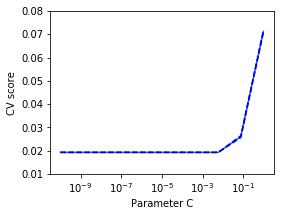

In [85]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.show()  

We try another range for C : 

In [29]:
C_s2 = np.linspace(0.5, 6, 3)

print(C_s2)

[0.5  3.25 6.  ]


In [ ]:
svc = svm.LinearSVC()

scores2 = list()
scores_std2 = list()
i = 0
for C in C_s2:
    print(i)
    svc.C = C
    this_scores = cross_validate(svc, Xnorm, y, cv=3, scoring=('f1_macro'), return_train_score=False)
    scores2.append(np.mean(this_scores['test_score']))
    scores_std2.append(np.std(this_scores['test_score']))
    i+=1

In [43]:
print('The maximum accuracy percentage obtained is : ',100*max(scores2), '%')
plt.figure(1, figsize=(4, 3))
plt.plot(C_s2, scores2)
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.show() 

The maximum accuracy percentage obtained is :  10.034196168314065 %


We reach an accuracy of **10%** what is better than previously but not acceptable for a correct clasifier...

* **Conclusion on Linear SVM**
---

Whatever the value of the hyparameter C, the best performance we can expect from Linear SVM is only 10% of accuracy regarding f1 score.. It seems that our dataset is not linearly separable. 
So perhaps a non-linear kernel would work better, such as the RBF kernel. 
However, keep in mind those kernels have more parameters and they have to be tuned to work well.

* **With non linear kernel**
---

In [38]:
from sklearn import svm
from sklearn.metrics import f1_score

clf = svm.SVC(kernel='rbf')
clf.fit(Xnorm_train, y_train) 

y_pred = clf.predict(Xnorm_test)
print(f1_score(y_test, y_pred, labels=classes, average='macro'))

0.019288807086928206


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The non linear version of SVM using RBF kernel is very slow to run and give back a really low score... 
We choose not to explore more in detail this option as we don't have enough time to do it and also because there is numerous hyperparameters to tune and which influences the complexity of model selection.

2-KNearestNeighbors
---

As Linear SVC has proven really poor efficiency, we try another method. We don't have any text label, so we explore the KNeighbors Classifier.

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.


* **A first try..**
---

We first implement the algorithm without any precaution on the parameter choice.

In [43]:
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

neigh = KNeighborsClassifier(n_neighbors=3, n_jobs=39)
neigh.fit(Xnorm_train, y_train)
y_pred_knn = neigh.predict(Xnorm_test)

In [46]:
score_av = f1_score(y_test.values, y_pred_knn, average=None)

print('f1 score : ',100*score, '%')

f1 score :  34.91353035719553 %


**Model accuracy**

Without any particular precautions, we obtain an accuracy of 34.9%. 
Let's have a closer look of the f1 score category by category to better evaluate the performances of the kNN.

In [112]:
import warnings
warnings.filterwarnings("ignore")

score = f1_score(y_test.values, y_pred_knn, average='macro')
score_av = f1_score(y_test.values, y_pred_knn, average=None)

cat_sort = np.sort()
print('f1 score : ',100*score, '%')

train = {'Category' : cat_sort, 
     'Accuracy percent' : score_av*100,
          } 
df = pd.DataFrame(train) 
df

f1 score :  34.91353035719553 %


Accuracy percent                        Category
0          22.988506                        Annelida
1          13.333333                Asterionellopsis
2           0.000000                   Bacteriastrum
3           3.448276             Ceratocorys horrida
4          47.858942                     Chaetoceros
5          25.806452                       Codonaria
6          71.636953  Codonellopsis (Dictyocystidae)
7          66.783677                        Copepoda
8          34.545455                  Coscinodiscids
9          42.105263                    Cyttarocylis
10         48.113208                     Dictyocysta
11          6.289308                   Dinophysiales
12         27.091633                       Hemiaulus
13          0.000000                 Lithodesmioides
14         71.447661                     Neoceratium
15          6.250000        Odontella (Mediophyceae)
16         19.354839                     Pleurosigma
17         18.932039                 Protoperidinium
18          8.219178                         Retaria
19         49.572650                     Rhabdonella
20         37.544274                   Rhizosolenids
21          8.888889                    Stenosemella
22         68.252788                   Thalassionema
23         51.798561                  Tintinnidiidae
24         53.380783                      Undellidae
25          0.000000                   Xystonellidae
26         60.975610                        artefact
27         92.662060             badfocus (artefact)
28          0.000000                         centric
29         14.414414                      chainlarge
30         86.377951                        detritus
31         24.050633                     egg (other)
32         58.585859                           feces
33         18.952062                multiple (other)
34         68.828338             nauplii (Crustacea)
35          4.545455                          pollen
36         58.980044                            rods
37         69.612591                           silks
38          0.000000         tempChaetoceros danicus

The conclusions that can be drawn is that the kNN is able to make predictions for almost all classes, more or less better. The classes that have a f1 score at 0 are of 2 types : 
* the classe is predicted but always as a False Positive (this classe is never well predicted)
* or, the classe is not predicted at all (False and True Negative), and so doesn't appear in the predictions `y_pred_knn`

If for the first type an f1 score at 0 is understandable, for the second type it is an extension that quite penalized the measuring of the global accuracy. Let's see how may classes are in this case.

In [107]:
print(set(y_test) - set(y_pred_knn))

{'tempChaetoceros danicus'}


Only one classe is concerned by the second case. The computation of the f1 score without considering it gives the following result :

In [110]:
score = f1_score(y_test.values, y_pred_knn, average='macro',labels=np.unique(y_pred_knn))
print(100*score, '%')

35.83230747185857 %


So, 5 classes are not completely unpredictable with this kNN. 
In order to solve this, let's do some optimization.

* **Optimization of k**
---

In order to improve it, we are going to apply the *Elbow method* to find the best value for the parameter k.
The best choice of k depends upon the data; generally, larger values of k reduces effect of the noise on the classification, but make boundaries between classes less distinct and increase the computation costs... To select a good k, we tried several values and compared their accuracy (always regarding f1 score).

The maximum accuracy is :  35.583327583020235 %


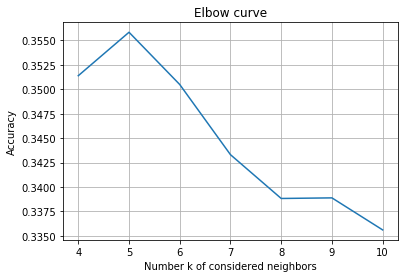

In [59]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

accuracy =[]

for k in range(4,11) :
    neigh = KNeighborsClassifier(n_neighbors=k, n_jobs=39)
    neigh.fit(Xnorm_train, y_train)
    y_pred_knn = neigh.predict(Xnorm_test)
    score = f1_score(y_test.values, y_pred_knn, average='macro') #,labels=np.unique(y_pred_knn)) 
    accuracy.append(score)
    print(k)

plt.plot(range(4,11), accuracy)
print('The maximum accuracy is : ', 100*max(accuracy),'%')
plt.xlabel('Number k of considered neighbors')
plt.ylabel('Accuracy')
plt.title('Elbow curve')
plt.grid()
plt.show()

Best value of k in terms of accuracy : **k=5**

We observe that the overall accuracy has not improve that much : the classifier stays around **35%** which remains quite a poor result. 

* **Conclusion for kNN classifier**

There are two main drawbacks of using kNN is our case : 

* KNN algorithm is the computationally expensive testing phase which is impractical in industry settings.

* The distribution of the dataset is skewed. Indeed, some classes are far more represented than others (the *detritus* represents more than the half the data !) and tend to dominate the majority voting of the new example (large number = more common). Finally, the accuracy of KNN can be severely degraded with high-dimension data because there is little difference between the nearest and farthest neighbor.

Following the sklearn flowchart, let's try ensemble methods !

3-Ensemble classifiers
----

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.
Two families of ensemble methods are usually distinguished:

* In **averaging methods**, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

*Examples: Bagging methods, Forests of randomized trees, …*
* By contrast, in **boosting methods**, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

*Examples: AdaBoost, Gradient Tree Boosting, …*

3.1- AVERAGING : RANDOM FOREST AND EXTRA TREES
---
---

**RANDOM FOREST CLASSIFIER**
---

Random forest is an ensemble tool which takes a subset of observations and a subset of variables to build a decision trees. It builds multiple such decision tree and amalgamate them together to get a more accurate and stable prediction. This is direct consequence of the fact that by maximum voting from a panel of independent judges, we get the final prediction better than the best judge.

Random forests is considered as a highly accurate and robust method because of the number of decision trees participating in the process.
It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.


* **A first try...**
---

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

clf = RandomForestClassifier(n_estimators=10, max_depth=50, random_state=0)
clf.fit(Xnorm_train, y_train) 

y_pred = clf.predict(Xnorm_test)
print(f1_score(y_test, y_pred, labels=classes, average='macro'))

0.4146434247403941


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Without optimization : **41.5%** of accuracy

There are primarily 2 features which can be tuned to improve the predictive power of the model :
* `depth` : the maximal depth of the tree to consider
* `n_estimator` : this is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower. You should choose as high value as your processor can handle because this makes your predictions stronger and more stable.


* **Choosing the depth**

We let the n_estimators fixed at 10 and try several values for the depth :

The maximum accuracy percentage is  43.04980292184798 % for a depth of  44


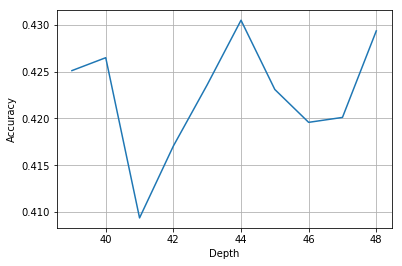

In [39]:
accuracy = []

for depth in range(39, 49) :
    clf = RandomForestClassifier(n_estimators=10, max_depth=depth, random_state=0)
    clf.fit(Xnorm_train, y_train) 
    y_pred = clf.predict(Xnorm_test)
    score = f1_score(y_test, y_pred, labels=classes, average='macro')
    accuracy.append(score)

x = range(39,49)
print('The maximum accuracy percentage is ', 100*max(accuracy), '% for a depth of ', x[accuracy.index(max(accuracy))])
plt.plot(x, accuracy)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

The maximum accuracy percentage is **43%** for a **depth of 44**. We keep this value for next section.

* **n_estimators**

In [35]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

accuracy = []

for est in range(10, 100) :
    clf = RandomForestClassifier(n_estimators=est, max_depth=44, random_state=0)
    clf.fit(Xnorm_train, y_train) 
    y_pred = clf.predict(Xnorm_test)
    score = f1_score(y_test, y_pred, labels=classes, average='macro')
    accuracy.append(score)
    
x = range(10,100)
print('The maximum accuracy percentage is ', 100*max(accuracy), '% for a number of estimators of ', x[accuracy.index(max(accuracy))])
plt.plot(x, accuracy)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

The maximum accuracy percentage is  43.04980292184798 % for a number of estimators of  10


The accuracy fluctuates substantially with the value of n_estimators. Regarding the fact that the higher n_estimators is, the more costly the computation is... 10 estimators seem to be enough to ensure good performances.

* **Conclusion on RandomForest classifier**
---

This type of classifier gives us the best accuracy until then. What's more, it is really fast to compute, only 30sec to fit the model and make predictions

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
import time

t0 = time.time()

clf = RandomForestClassifier(n_estimators=10, max_depth=44, random_state=0)
clf.fit(Xnorm_train, y_train) 
y_pred = clf.predict(Xnorm_test)

print('The f1 score : ', f1_score(y_test, y_pred, labels=classes, average='macro'), '%')
print('The running time : ', time.time() - t0, 'sec')

The f1 score :  43.04980292184798 % 
The running time :  30.989701986312866 sec


Let's have a closer look to f1 score by classes :

In [35]:
cat_sort = np.sort(y_test.unique())
score = f1_score(y_test, y_pred, labels=classes, average=None)
acc_rf = {'Category' : cat_sort, 
     'Accuracy percent' : score*100,
          } 
df = pd.DataFrame(acc_rf) 
df

Accuracy percent                        Category
0          90.257146                        Annelida
1          50.316456                Asterionellopsis
2          88.042328                   Bacteriastrum
3          74.075303             Ceratocorys horrida
4          63.636364                     Chaetoceros
5          12.500000                       Codonaria
6          86.082949  Codonellopsis (Dictyocystidae)
7          68.235294                        Copepoda
8          84.330629                  Coscinodiscids
9          77.204819                    Cyttarocylis
10         50.632911                     Dictyocysta
11         79.160021                   Dinophysiales
12         33.898305                       Hemiaulus
13         25.925926                 Lithodesmioides
14          0.000000                     Neoceratium
15          4.123711        Odontella (Mediophyceae)
16         65.079365                     Pleurosigma
17         81.761978                 Protoperidinium
18         69.651741                         Retaria
19         79.402348                     Rhabdonella
20         13.432836                   Rhizosolenids
21         63.908702                    Stenosemella
22         20.000000                   Thalassionema
23         34.375000                  Tintinnidiidae
24         21.327014                      Undellidae
25         59.047619                   Xystonellidae
26         12.021858                        artefact
27         57.627119             badfocus (artefact)
28         10.000000                         centric
29          0.000000                      chainlarge
30          7.142857                        detritus
31         47.619048                     egg (other)
32         95.027624                           feces
33         37.575758                multiple (other)
34         12.500000             nauplii (Crustacea)
35          0.000000                          pollen
36          0.000000                            rods
37          0.000000                           silks
38          0.000000         tempChaetoceros danicus

In [36]:
print(set(y_test)-set(y_pred))

{'tempChaetoceros danicus', 'Ceratocorys horrida', 'Bacteriastrum', 'Odontella (Mediophyceae)', 'Xystonellidae', 'Lithodesmioides'}


Here again 6 classes have null f1 score but here because those classes, when appearing in the test set, are all considered either as True Negative or False Negative.

**EXTRA TREES CLASSIFIER**
---

ExtraTrees classifiers are a variant of a RandomForest ones. Unlike a random forest, at each step the entire sample is used and decision boundaries are picked at random, rather than the best one. In real world cases, performance is comparable to an ordinary random forest, sometimes a bit better.
This type of classifiers can prove to be as accurate and faster than RandomTrees.

* **A first try**
---

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
import time
import warnings
warnings.filterwarnings("ignore")

t0 = time.time()
clf = ExtraTreesClassifier(n_estimators=10, max_depth=44, random_state=0)
clf.fit(Xnorm_train, y_train) 
y_pred = clf.predict(Xnorm_test)

t1 = time.time()
print("The f1 score : ", 100*f1_score(y_test, y_pred, labels=classes, average='macro'), '%')
print('The running time is : ', t1-t0, 'sec')

The f1 score :  39.88383591962136 %
The running time is :  7.944610595703125 sec


The accuracy, without any particular precaution taken, is lower than the 41.5% provided by RandomForest but the algorithm is way much faster (at least 4 time faster !).

* **Choosing the depth**

The maximum accuracy percentage is  41.748539778638246 % for a depth of  46


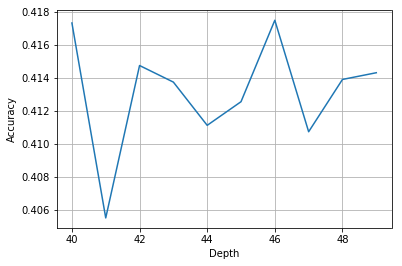

In [35]:
accuracy = []
for depth in range(40,50) :
    clf = ExtraTreesClassifier(n_estimators=100, max_depth=depth, random_state=0)
    clf.fit(Xnorm_train, y_train) 
    y_pred = clf.predict(Xnorm_test)
    score = f1_score(y_test, y_pred, labels=classes, average='macro')
    accuracy.append(score)
    print(depth)
    
x = range(40,50)
print('The maximum accuracy percentage is ', 100*max(accuracy), '% for a depth of ', x[accuracy.index(max(accuracy))])
plt.plot(x, accuracy)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

By putting the depth value to 46, the f1 score is improved at **41,7%**, which is always less than RandomForest but obtained much faster.

3.2- AVERAGING : BAGGING
---
---

We have chosen to test bagging with two weak classifiers such as kNN and DecisionTrees in order to improve their accuracy.

* **Bagging methods using kNN**
---

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=5, n_jobs=39))  #, max_samples=0., max_features=0.99)
bagging.fit(Xnorm_train, y_train)
y_pred_knn = bagging.predict(Xnorm_test)

In [35]:
accuracy_bag = f1_score(y_test.values, y_pred_knn, average='macro')
print(accuracy_bag)

0.33031533899890203


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy obtained : **33%**... It seems that in that case, bagging doesn't improve the performances of the kNN classifier. Let's try with **Decision trees**.

* **Bagging methods using Decision Trees**
---

Decision trees performs quite poorly, even when using the optimal parameters :

In [33]:
from sklearn.tree import DecisionTreeClassifier

t0 = time.time()
clf = (DecisionTreeClassifier(max_depth=44))
clf.fit(Xnorm_train, y_train)
y_pred_knn = clf.predict(Xnorm_test)

t1 = time.time()
accuracy_bag = f1_score(y_test.values, y_pred_knn, average='macro')
print('The running time is : ', t1 - t0, 'sec')

The running time is :  69.68532705307007 sec


In [34]:
print('The f1 score is :',100*accuracy_bag, '%')

The f1 score is : 36.46409456551161 %


The maximum accuracy reached is **36%** using a DecisionTree alone. Let's see the impact of bagging method :

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

t0 = time.time()
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=44), n_estimators = 30) 
bagging.fit(Xnorm_train, y_train)
y_pred_knn = bagging.predict(Xnorm_test)

t1 = time.time()
accuracy_bag = f1_score(y_test.values, y_pred_knn, average='macro')
print('The running time is : ', t1 - t0, 'sec')

The running time is :  1038.7318494319916 sec


In [41]:
print('The f1 score is :',100*accuracy_bag, '%')

The f1 score is : 45.10997559645307 %


Using the parameters found above, the bagging method performs quite well on DecisionTrees as we obtain our best accuracy until now !

* **f1 score per category**
---

In [39]:
cat_sort = np.sort(y_test.unique())
score = f1_score(y_test, y_pred_knn, labels=classes, average=None)
acc_rf = {'Category' : cat_sort, 
     'Accuracy percent' : score*100,
          } 
df = pd.DataFrame(acc_rf) 
df

Accuracy percent                        Category
0          90.465969                        Annelida
1          54.197349                Asterionellopsis
2          87.909726                   Bacteriastrum
3          75.254015             Ceratocorys horrida
4          56.744186                     Chaetoceros
5          12.500000                       Codonaria
6          84.509624  Codonellopsis (Dictyocystidae)
7          62.962963                        Copepoda
8          84.739768                  Coscinodiscids
9          77.184466                    Cyttarocylis
10         52.500000                     Dictyocysta
11         78.775079                   Dinophysiales
12         44.881890                       Hemiaulus
13         17.475728                 Lithodesmioides
14          0.000000                     Neoceratium
15          4.081633        Odontella (Mediophyceae)
16         67.078825                     Pleurosigma
17         84.042553                 Protoperidinium
18         71.921182                         Retaria
19         78.846154                     Rhabdonella
20         28.378378                   Rhizosolenids
21         65.428571                    Stenosemella
22         19.780220                   Thalassionema
23         29.508197                  Tintinnidiidae
24         28.509249                      Undellidae
25         64.220183                   Xystonellidae
26         17.258883                        artefact
27         57.627119             badfocus (artefact)
28         31.111111                         centric
29         12.500000                      chainlarge
30          0.000000                        detritus
31         47.619048                     egg (other)
32         94.970986                           feces
33         43.575419                multiple (other)
34         21.818182             nauplii (Crustacea)
35          0.000000                          pollen
36          0.000000                            rods
37          0.000000                           silks
38          0.000000         tempChaetoceros danicus

Even with a higher f1 core, we see that we always have 6 classes which are always totally wrongly predicted...

3.3- BOOSTING : ADABOOST
---
---

Ada-boost is one of ensemble boosting classifier. It combines multiple classifiers to increase the accuracy of classifiers. AdaBoost is an iterative ensemble method. AdaBoost classifier builds a strong classifier by combining multiple poorly performing classifiers so that you will get high accuracy strong classifier. The basic concept behind Adaboost is to set the weights of classifiers and training the data sample in each iteration such that it ensures the accurate predictions of unusual observations. Any machine learning algorithm can be used as base classifier if it accepts weights on the training set (it is not the case of kNN algorithms).

The most important parameters to tune : 
* base_estimator: It is a weak learner used to train the model. It uses DecisionTreeClassifier as default weak learner for training purpose. You can also specify different machine learning algorithms.
* n_estimators: Number of weak learners to train iteratively.
* learning_rate: It contributes to the weights of weak learners. It uses 1 as a default value.

Concerning the base estimator, for a question of computation time, we choose to work with Decision trees only using the optimal tree depth found above : `base_estimator = DecisionTreeClassifier(max_depth=44)`.

The n_estimators will also be set to the optimal value found above : `n_estimators = 10`.

In this section we will try to optimize the learning rate parameter.

* **Working on learning rate with Decision tree depth = 44**
---

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time

l_rate = [0.5,0.6,0.7,0.8, 1]
accuracy_ada = []

for l in l_rate :
    clf = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=44),n_estimators=10, learning_rate = l)
    clf.fit(Xnorm_train, y_train)
    y_pred_ada = clf.predict(Xnorm_test)
    score = f1_score(y_test.values, y_pred_ada, average='macro') 
    accuracy_ada.append(score)

The max accuracy obtained is :  0.44285164509183533


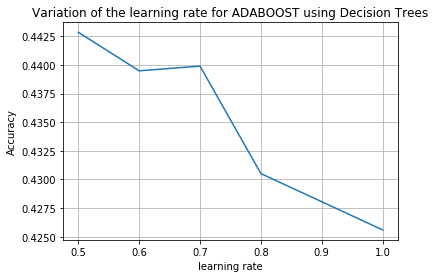

In [40]:
print('The max accuracy obtained is : ', max(accuracy_ada))
plt.plot(l_rate, accuracy_ada)
plt.title('Variation of the learning rate for ADABOOST using Decision Trees')
plt.xlabel('learning rate')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

The best learning rate : **0.5**.

* **Per category accuracy** 
---

For the best combination ie depth= 43 and l_rate= 0.5, we look closer to the accuracy per category to better understand the performance of the classifier.

In [41]:
t0 = time.time()

clf = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=44),n_estimators=10, learning_rate = 0.5)
clf.fit(Xnorm_train, y_train)
y_pred_ada = clf.predict(Xnorm_test)
score = f1_score(y_test.values, y_pred_ada, average='macro') 

t1 = time.time()
print('f1 score : ',100*score, '%')
print('The running time is : ', t1 - t0, 'sec')

f1 score :  43.04289928784911 %
The running time is :  594.8776943683624 sec


In [44]:
cat_sort = np.sort(y_test.unique())
score = f1_score(y_test.values, y_pred_ada, average=None) 

acc_ada = {'Category' : cat_sort, 
     'Accuracy_ada percent' : score*100,
          } 
df = pd.DataFrame(acc_ada) 
df

Accuracy_ada percent                        Category
0              23.008850                        Annelida
1               0.000000                Asterionellopsis
2               0.000000                   Bacteriastrum
3               0.000000             Ceratocorys horrida
4              64.784547                     Chaetoceros
5              52.719665                       Codonaria
6              83.257091  Codonellopsis (Dictyocystidae)
7              74.807692                        Copepoda
8              58.139535                  Coscinodiscids
9              28.571429                    Cyttarocylis
10             65.060241                     Dictyocysta
11              5.769231                   Dinophysiales
12             20.833333                       Hemiaulus
13              0.000000                 Lithodesmioides
14             81.784014                     Neoceratium
15              0.000000        Odontella (Mediophyceae)
16             31.111111                     Pleurosigma
17             39.849624                 Protoperidinium
18             16.949153                         Retaria
19             53.465347                     Rhabdonella
20             50.377074                   Rhizosolenids
21             31.746032                    Stenosemella
22             79.598145                   Thalassionema
23             61.756374                  Tintinnidiidae
24             70.046083                      Undellidae
25              0.000000                   Xystonellidae
26             63.636364                        artefact
27             94.505495             badfocus (artefact)
28              6.666667                         centric
29             19.900498                      chainlarge
30             89.695780                        detritus
31             45.054945                     egg (other)
32             73.706339                           feces
33             25.177665                multiple (other)
34             77.000530             nauplii (Crustacea)
35             26.415094                          pollen
36             76.763485                            rods
37             86.515642                           silks
38              0.000000         tempChaetoceros danicus

As previously observed, 6 categories are not well predicted at all and having an f1 score of 0. The averall accuracy remains one of the highest observed in this notebook **44,8%**.

# Model Evaluation


* **THE RESULTING CHOSEN MODEL**
---

It is clear that for a real life application, none of the produced models can be used as they are. 
But the two best to which we came to is  the Bagging Classifier used with Decision trees with an accuracy of **45.1%** and the Adaboost model with the same Decision trees (**44.7%** accuracy).

Both are similar in term of accuracy and also of spatial complexity, which can be approximate at $O( n_{estimators} \times n_{samples} \times log(n_{samples}))$. 
The main difference is observed when it comes to the computation time : for bagging the global running time for fitting and prediction is 17min and for boosting it's less than 10min...

When choosing the best, it is important to consider if a parallelization can be opered to improve performance. In a bagging approach, as subset are chosen randomly and independently,the parallelization appears to be straighforward. That's not the case for boosting which parallelization is more tricky to implement.
For more details, this paper provides a study on both bagging and boosting parallelization methods : https://pdfs.semanticscholar.org/16a4/aa3acee78eb8bd9754bd53d46b2d94ed37bf.pdf .

# Conclusion


At the end of this evaluation study, we have explored two different ways to deal with data classification. 

For the first, using convolutionnal neural network, our models are clearly not performant enough. Several points can explain this :

* the main point is probably due the fact we didn't found the best architecture for our CNN.. It is the harder part to know what best suits to our problem and what to put inside the "black box".
* regarding the data pre-processing, we didn't proceed to data augmentation in order to reduce the skew character of our dataset and also the rescaling of all images to a 32x32 size was clearly not optimal but allows us to gain in term of time computation efficiency.
* we really intend to use Dataloaders in order to process the data "on the fly" and in-memory before passing it to the network. But this lead to a very slow computation time.

At the end, we didn't succeed to reach an f1 score higher than 5%...

For the features approach, we have tried several techniques following the scikit-learn flowchart for multi-labels classification methods. Three main categories of alogorithms were tested : 

* the SVMs based on linear SVC and non-linear with RBF kernels, which both performed poorly on our dataset (**10%** for f1 score in the best case)
* the kNN classifier, which improve the accuracy we obtained until there to **35%**. Maybe by working at reducing the skew character of our dataset, the performances could be increase more.
* the ensemble methods through bagging and boosting. In that case, we reached our highest f1 score **45,1%** 